In [1]:
from sklearn.model_selection import train_test_split
from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.schedulers.blocking import BlockingScheduler
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient
from dotenv import load_dotenv
import pandas as pd
import datetime
import requests
import joblib
import os

### 데이터 수집

In [2]:
# InfluxDB 접속 정보 불러오기
load_dotenv('secret.env')

DB_URL=os.getenv('DB_URL')
DB_TOKEN=os.getenv('DB_TOKEN')
DB_ORG=os.getenv('DB_ORG')
DB_BUCKET=os.getenv('DB_BUCKET')

In [3]:
# InfluxDB에서 주어진 측정치에 대한 데이터를 조회하여 DataFrame으로 반환.
def query_influx(measurement):
    client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
    query_api = client.query_api()
    
    query = f'''
    import "date"
    import "influxdata/influxdb/schema"
    from(bucket: "{DB_BUCKET}")
      |> range(start: date.sub(d: 7d, from: date.truncate(t: now(), unit: 1d)), stop: now())
      |> filter(fn: (r) => r["_measurement"] == "{measurement}")
      |> schema.fieldsAsCols()
    '''
    
    result_df = query_api.query_data_frame(org=DB_ORG, query=query)
    print(f"{measurement} shape: ", result_df.shape)
    
    client.close()
    return result_df

temperature_df = query_influx("temperature")
humidity_df = query_influx("humidity")
people_count_df = query_influx("total_people_count")
magnet_status_df = query_influx("magnet_status")


temperature shape:  (27843, 10)
humidity shape:  (27384, 10)
total_people_count shape:  (5463, 10)
magnet_status shape:  (401, 10)


### 데이터 전처리

In [4]:
# class A에 있는 센서값만 보도록 수정
def filter_by_place(df, place):
    
    return df[df['place'] == place]

# 필요없는 컬럼 삭제 및 한국시간으로 시간대 변환
def clean_and_convert_time(df):
    df = df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_convert('Asia/Seoul').dt.tz_localize(None)
    
    return df


temperature_class_a_df = filter_by_place(temperature_df, 'class_a')
humidity_class_a_df = filter_by_place(humidity_df, 'class_a')

temperature_class_a_df = clean_and_convert_time(temperature_class_a_df)
humidity_class_a_df = clean_and_convert_time(humidity_class_a_df)
people_count_df = clean_and_convert_time(people_count_df)
magnet_status_df = clean_and_convert_time(magnet_status_df)

In [5]:
print("info : ", temperature_class_a_df.head(), '\n')
print("info : ", humidity_class_a_df.head(), '\n')
print("info : ", people_count_df.head(), '\n')
print("info : ", magnet_status_df.head(), '\n')

info :                          _time _measurement    place      value
0  2024-04-19 14:43:51.540435  temperature  class_a  24.299999
2  2024-04-19 14:45:25.074113  temperature  class_a  23.400000
6  2024-04-19 14:45:49.959823  temperature  class_a  24.400000
8  2024-04-19 14:46:10.411416  temperature  class_a  24.200001
12 2024-04-19 14:46:49.685429  temperature  class_a  24.400000 

info :                          _time _measurement    place  value
0  2024-04-19 14:43:50.374828     humidity  class_a   42.5
2  2024-04-19 14:45:25.066652     humidity  class_a   49.0
6  2024-04-19 14:45:49.950731     humidity  class_a   43.0
8  2024-04-19 14:46:10.424577     humidity  class_a   45.5
12 2024-04-19 14:46:49.699407     humidity  class_a   42.5 

info :                         _time        _measurement    place  value
0 2024-04-19 14:43:46.166698  total_people_count  class_a    9.0
1 2024-04-19 14:45:10.564579  total_people_count  class_a    8.0
2 2024-04-19 14:45:39.585428  total_people_co

In [6]:
# resample로 1분단위로 데이터를 합치기 위해 Datetime을 인덱스로 지정
# value에 대해 1분 단위로 평균 or 마지막값 계산. resample을 수행한 후에는 Series 객체가 됨.
def resample_data(df, column, freq, method):
    df = df.set_index('_time')

    if method == 'mean':
        return df[column].resample(freq).mean()
    elif method == 'last':
        return df[column].resample(freq).last()

temperature_summary_series = resample_data(temperature_class_a_df, 'value', 'T', 'mean')
humidity_summary_series = resample_data(humidity_class_a_df, 'value', 'T', 'mean')
people_count_series = resample_data(people_count_df, 'value', 'T', 'last')
magnet_status_series = resample_data(magnet_status_df, 'value', 'T', 'last')

print(temperature_summary_series.head(),'\n', humidity_summary_series.head(),'\n', people_count_series.head(),'\n',magnet_status_series.head(),'\n')

_time
2024-04-19 14:43:00    24.299999
2024-04-19 14:44:00          NaN
2024-04-19 14:45:00    23.900000
2024-04-19 14:46:00    24.300000
2024-04-19 14:47:00    24.080000
Freq: T, Name: value, dtype: float64 
 _time
2024-04-19 14:43:00    42.5
2024-04-19 14:44:00     NaN
2024-04-19 14:45:00    46.0
2024-04-19 14:46:00    44.0
2024-04-19 14:47:00    45.3
Freq: T, Name: value, dtype: float64 
 _time
2024-04-19 14:43:00    9.0
2024-04-19 14:44:00    NaN
2024-04-19 14:45:00    7.0
2024-04-19 14:46:00    9.0
2024-04-19 14:47:00    9.0
Freq: T, Name: value, dtype: float64 
 _time
2024-04-19 14:49:00    open
2024-04-19 14:50:00    None
2024-04-19 14:51:00    None
2024-04-19 14:52:00    None
2024-04-19 14:53:00    None
Freq: T, Name: value, dtype: object 



In [7]:
data_df = pd.DataFrame({
    'temperature': temperature_summary_series,
    'humidity': humidity_summary_series,
    'people_count': people_count_series,
    'air_conditional': magnet_status_series
})

print(data_df)

                     temperature   humidity  people_count air_conditional
_time                                                                    
2024-04-19 14:43:00    24.299999  42.500000           9.0             NaN
2024-04-19 14:44:00          NaN        NaN           NaN             NaN
2024-04-19 14:45:00    23.900000  46.000000           7.0             NaN
2024-04-19 14:46:00    24.300000  44.000000           9.0             NaN
2024-04-19 14:47:00    24.080000  45.300000           9.0             NaN
...                          ...        ...           ...             ...
2024-04-22 09:18:00    24.000000  49.250000           6.0           close
2024-04-22 09:19:00    23.700000  50.666667           4.0             NaN
2024-04-22 09:20:00    24.050000  49.000000           4.0             NaN
2024-04-22 09:21:00    23.700000  50.666667           4.0             NaN
2024-04-22 09:22:00    23.900000  50.000000           5.0             NaN

[4000 rows x 4 columns]


In [8]:
null_values = data_df.isnull().sum()
print('Initial null value:\n', null_values)

# 'air_conditional' 컬럼의 첫 번째 값이 결측치인 경우 'close'로 설정
if pd.isna(data_df.loc[data_df.index[0], 'air_conditional']):
    data_df.at[data_df.index[0], 'air_conditional'] = 'close'


# people_count' 컬럼에서 첫 번째 값이 결측치인 경우, 최근 유효 값으로 채우기
if pd.isna(data_df.loc[data_df.index[0], 'people_count']):
    notnull_peoplecount = data_df[data_df['people_count'].notnull()].iloc[0]['people_count']
    data_df.at[data_df.index[0], 'people_count'] = notnull_peoplecount

# 나머지 결측치 전방 채우기
data_df_filled = data_df.fillna(method='ffill', axis=0)

print('After processing null value: \n', data_df_filled.isnull().sum())

Initial null value:
 temperature          10
humidity             10
people_count         52
air_conditional    3599
dtype: int64
After processing null value: 
 temperature        0
humidity           0
people_count       0
air_conditional    0
dtype: int64


In [9]:
print(data_df_filled)
print(data_df_filled.shape)

                     temperature   humidity  people_count air_conditional
_time                                                                    
2024-04-19 14:43:00    24.299999  42.500000           9.0           close
2024-04-19 14:44:00    24.299999  42.500000           9.0           close
2024-04-19 14:45:00    23.900000  46.000000           7.0           close
2024-04-19 14:46:00    24.300000  44.000000           9.0           close
2024-04-19 14:47:00    24.080000  45.300000           9.0           close
...                          ...        ...           ...             ...
2024-04-22 09:18:00    24.000000  49.250000           6.0           close
2024-04-22 09:19:00    23.700000  50.666667           4.0           close
2024-04-22 09:20:00    24.050000  49.000000           4.0           close
2024-04-22 09:21:00    23.700000  50.666667           4.0           close
2024-04-22 09:22:00    23.900000  50.000000           5.0           close

[4000 rows x 4 columns]
(4000, 4)


In [10]:
# 날짜값 제거
data_df_filled.index = data_df_filled.index.time
print(data_df_filled.head())

          temperature  humidity  people_count air_conditional
14:43:00    24.299999      42.5           9.0           close
14:44:00    24.299999      42.5           9.0           close
14:45:00    23.900000      46.0           7.0           close
14:46:00    24.300000      44.0           9.0           close
14:47:00    24.080000      45.3           9.0           close


In [11]:
# air_conditional의 값이 close면 0, open이면 1로 변경
data_df_filled['air_conditional'] = data_df_filled['air_conditional'].map({'close': 0, 'open': 1})

print(data_df_filled.head())
print(data_df_filled.info)

          temperature  humidity  people_count  air_conditional
14:43:00    24.299999      42.5           9.0                0
14:44:00    24.299999      42.5           9.0                0
14:45:00    23.900000      46.0           7.0                0
14:46:00    24.300000      44.0           9.0                0
14:47:00    24.080000      45.3           9.0                0
<bound method DataFrame.info of           temperature   humidity  people_count  air_conditional
14:43:00    24.299999  42.500000           9.0                0
14:44:00    24.299999  42.500000           9.0                0
14:45:00    23.900000  46.000000           7.0                0
14:46:00    24.300000  44.000000           9.0                0
14:47:00    24.080000  45.300000           9.0                0
...               ...        ...           ...              ...
09:18:00    24.000000  49.250000           6.0                0
09:19:00    23.700000  50.666667           4.0                0
09:20:00    24

In [12]:
# 상관계수 계산
correlation_matrix = data_df_filled.corr()
print(correlation_matrix)

                 temperature  humidity  people_count  air_conditional
temperature         1.000000 -0.002927      0.350761        -0.150126
humidity           -0.002927  1.000000     -0.132839        -0.109673
people_count        0.350761 -0.132839      1.000000         0.453113
air_conditional    -0.150126 -0.109673      0.453113         1.000000


### 데이터 시각화

/home/gahyoung/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


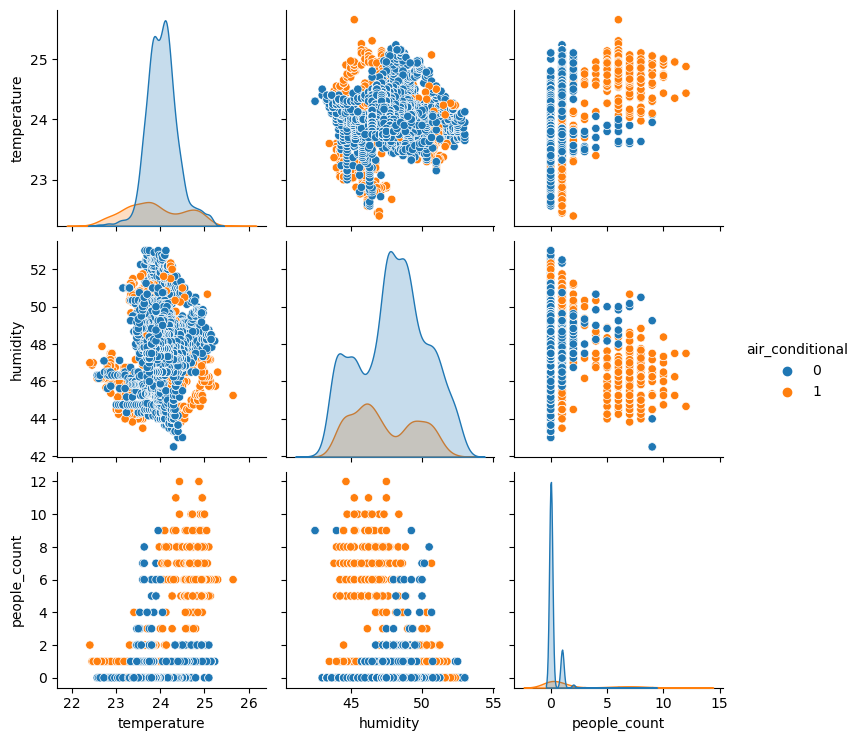

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 그리기
sns.pairplot(data_df_filled, hue='air_conditional', vars=['temperature', 'humidity', 'people_count'])
plt.show()

### 모델링
1. 데이터 분할

In [14]:
# 훈련데이터와 테스트 데이터 분리
X = data_df_filled[['temperature', 'humidity', 'people_count']]
y = data_df_filled['air_conditional']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. 모델 훈련 및 평가

In [15]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터 준비: X는 온도와 습도, y는 에어컨의 ON/OFF 상태
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# 모델 평가
from sklearn.metrics import accuracy_score
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [16]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

In [17]:
# XG 부스트
import xgboost as xgb

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# 예측 및 성능 평가
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)

In [18]:
print("LogisticRegression Accuracy:", log_reg_accuracy)
print("RandomForest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgboost_accuracy)

LogisticRegression Accuracy: 0.87625
RandomForest Accuracy: 0.92875
XGBoost Accuracy: 0.93375


In [19]:
print(y.value_counts())

0    3202
1     798
Name: air_conditional, dtype: int64


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_predictions))
print(classification_report(y_test, rf_predictions))
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       636
           1       0.86      0.48      0.61       164

    accuracy                           0.88       800
   macro avg       0.87      0.73      0.77       800
weighted avg       0.87      0.88      0.86       800

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       636
           1       0.88      0.76      0.81       164

    accuracy                           0.93       800
   macro avg       0.91      0.86      0.88       800
weighted avg       0.93      0.93      0.93       800

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       636
           1       0.91      0.76      0.82       164

    accuracy                           0.93       800
   macro avg       0.92      0.87      0.89       800
weighted avg       0.93      0.93      0.93       800



3. 모델 선택

In [21]:
# 모델 저장 경로와 파일 이름 설정
MODEL_NAME = 'air_conditional_ai_model.joblib'
MODEL_PATH = './' 

# 모델 저장
joblib.dump(rf_model, MODEL_PATH + MODEL_NAME)

['./air_conditional_ai_model.joblib']

### NHN Cloud Object Storage에 모델 업로드

In [22]:
class ObjectService:
    def __init__(self, storage_url, token_id):
        self.storage_url = storage_url
        self.token_id = token_id

    def _get_url(self, container, object):
        return '/'.join([self.storage_url, container, object])

    def _get_request_header(self):
        return {'X-Auth-Token': self.token_id}

    def upload(self, container, object, object_path):
        req_url = self._get_url(container, object)
        req_header = self._get_request_header()

        path = '/'.join([object_path, object])
        with open(path, 'rb') as f:
            return requests.put(req_url, headers=req_header, data=f.read())


if __name__ == '__main__':

    STORAGE_URL = os.getenv('STORAGE_URL')
    ACCESS_TOKEN_ID = os.getenv('ACCESS_TOKEN_ID')
    CONTAINER_NAME = os.getenv('CONTAINER_NAME')
    OBJECT_PATH = '.' 
    
    obj_service = ObjectService(STORAGE_URL, ACCESS_TOKEN_ID)

    obj_service.upload(CONTAINER_NAME, MODEL_NAME, OBJECT_PATH)